In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DRIVE_PATH'] + '/' + '/'.join(folders) + '/' + fname)

file_path = get_data_path(['SL PRED', 'input', 'gemini'], 'ito_pairs_annotated.csv')
figure_path_a = get_data_path(['SL PRED', 'Fig 2'], 'network_box_plots.png')
figure_path_b = get_data_path(['SL PRED', 'Fig 2'], 'indv_network_feature_aucs.png')

In [3]:
# load dataframe
df = pd.read_csv(file_path)
df.head()

,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,smallest_GO_CC_gene_effect,min_GO_CC_gene_z_effect,max_GO_CC_gene_z_effect,smallest_GO_CC_gene_z_effect,prediction_score,GEMINI,LFC,SL_1,SL_08,SL_06
0,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,-0.104289,-0.021442,0.029952,0.003538,0.012559,0.118768,0.088856,False,False,False
1,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,-0.103074,-0.032004,0.021698,-0.010239,0.012559,0.132501,0.201704,False,False,False
2,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,-0.099791,-0.018027,0.022543,-0.000695,0.012559,0.024593,0.069772,False,False,False
3,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000681,A549_LUNG,0.977988,0.379455,False,...,-0.095668,-0.012634,0.034220,0.009562,0.012559,-0.241323,0.379455,False,False,False
4,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000756,GI1_CENTRAL_NERVOUS_SYSTEM,0.999586,-0.077118,False,...,-0.097826,-0.013141,0.044570,0.018164,0.012559,0.299715,-0.077118,False,False,False


In [4]:
# remove NA values
features = ['zMaxExp_A1A2', 'zMinExp_A1A2', 'rMaxExp_A1A2', 'rMinExp_A1A2',
            'z_max_ranked_A1A2', 'z_min_ranked_A1A2', 'max_ranked_A1A2', 'min_ranked_A1A2',
            'max_cn', 'min_cn', 'Protein_Altering', 'Damaging', 'max_seq_id', 'min_seq_id',
            'ranked_BioGRID_ALL', 'ranked_zBioGRID_ALL', 
            'ranked_Essentiality_weighted_PPI', 'ranked_Essentiality_weighted_zPPI',
            'min_GO_ranked_ess', 'max_GO_ranked_ess', 'smallest_GO_ranked_ess',
            'min_GO_CC_ranked_ess', 'max_GO_CC_ranked_ess', 'smallest_GO_CC_ranked_ess',
            'Expression_weighted_PPI', 'Expression_weighted_zPPI',
            'max_gene_expression', 'min_gene_expression', 'smallest_gene_expression',
            'min_GO_CC_expression', 'max_GO_CC_expression', 'smallest_GO_CC_expression']

target = 'SL_08'

In [5]:
#remove NA values before training the model
df_clean = df.dropna(axis=0, how='any', subset=features + [target]).reset_index(drop=True) 

#summary of the training dataset after removing NA values
print(f"Num SL: {df_clean[df_clean[target] == True].shape[0]} / {df_clean.shape[0]}")
print(f"Num non-SL: {df_clean[df_clean[target] == False].shape[0]} / {df_clean.shape[0]}")
print(f'Number of unique gene pairs: {df_clean.genepair.nunique()}')
print(f'Number of unique cell lines: {df_clean.cell_line.nunique()}')
df_clean[:3]

Num SL: 358 / 41181
Num non-SL: 40823 / 41181
Number of unique gene pairs: 4161
Number of unique cell lines: 10


,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,smallest_GO_CC_gene_effect,min_GO_CC_gene_z_effect,max_GO_CC_gene_z_effect,smallest_GO_CC_gene_z_effect,prediction_score,GEMINI,LFC,SL_1,SL_08,SL_06
0,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,-0.104289,-0.021442,0.029952,0.003538,0.012559,0.118768,0.088856,False,False,False
1,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,-0.103074,-0.032004,0.021698,-0.010239,0.012559,0.132501,0.201704,False,False,False
2,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,-0.099791,-0.018027,0.022543,-0.000695,0.012559,0.024593,0.069772,False,False,False


In [6]:
rows_removed = len(df) - len(df_clean)
print(f"Rows removed due to missing values: {rows_removed} ({rows_removed / len(df):.2%})")

Rows removed due to missing values: 8152 (16.52%)


### Individual Feature Analysis: Predictive Power of Network related Features

### Bar plot

This section visualizes the predictive power (ROC AUC and PR AUC) of individual network-based features. 

The resulting bar plot helps identify which features independently contribute most to the prediction of synthetic lethality.

In [7]:
features_dict = [
    {"name": "ranked_BioGRID_ALL", "label": "Essentiality of Shared PPIs (BG_ALL)", "category": "essentiality"},
    {"name": "ranked_Essentiality_weighted_PPI", "label": "Essentiality of Shared wPPIs", "category": "essentiality"},
    {"name": "smallest_GO_ranked_ess", "label": "GO BP Essentiality (smallest)", "category": "essentiality"},
    {"name": "smallest_GO_CC_ranked_ess", "label": "GO CC Essentiality (smallest)", "category": "essentiality"},
    {"name": "Expression_weighted_PPI", "label": "Expression of Shared wPPIs", "category": "expression"},
    {"name": "smallest_gene_expression", "label": "GO BP Expression (smallest)", "category": "expression"},
    {"name": "smallest_GO_CC_expression", "label": "GO CC Expression (smallest)", "category": "expression"},
    {"name": "max_seq_id", "label": "Sequence Identity", "category": "sequence"},
]

# Extract specific information dynamically if needed
feature_columns = [f["name"] for f in features_dict]
labels = [f["label"] for f in features_dict]
categories = [f["category"] for f in features_dict]

# Target column
target_column = "SL_08"


In [8]:
def calculate_predictive_power(df, feature_columns, target_column, labels, categories):
    data, target = df[feature_columns], df[target_column]
    
    # Define the number of folds for the cross-validation
    n_folds = 5

    # Define the number of repetitions
    n_repeats = 10
    
    # Create a RepeatedStratifiedKFold object
    rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)

    # Initialize lists to store the average ROC-AUC and average precision values for each feature
    mean_aucs = []
    mean_prs = []

    # Calculate baseline PR AUC
    baseline_pr_auc = np.sum(target) / len(target)
    print(f'Baseline PR AUC: {baseline_pr_auc:.4f}')

    # Iterate over each feature
    for feature_name in feature_columns:
        # Get the feature data
        feature = data[feature_name].values
        aucs = []
        aps = []

        # Calculate the ROC AUC for both positive and negative directions
        pos_direction = roc_auc_score(target, feature)
        neg_direction = roc_auc_score(target, -feature)

        # If the ROC AUC is higher for the negative direction, then flip the feature
        if neg_direction > pos_direction:
            feature = -feature

        # Perform cross-validation
        for train_index, test_index in rskf.split(feature, target):
            train_target, test_target = target[train_index], target[test_index]
            train_feature, test_feature = feature[train_index], feature[test_index]
            
            # Calculate the ROC AUC for the feature
            auc = roc_auc_score(test_target, test_feature)
            aucs.append(auc)
            
            # Calculate the average precision for the feature
            avg_precision = average_precision_score(test_target, test_feature)
            aps.append(avg_precision)

        mean_auc = np.mean(aucs)
        mean_pr = np.mean(aps)

        mean_aucs.append(mean_auc)
        mean_prs.append(mean_pr)

        print(f'Mean ROC AUC for feature {feature_name} over {n_folds * n_repeats} iterations: {mean_auc}')
        print(f'Average precision for feature {feature_name} over {n_folds * n_repeats} iterations: {mean_pr}')

    # Create a pandas DataFrame from the list of mean ROC AUC values
    pred_df = pd.DataFrame({
        'feature': feature_columns,
        'mean_roc_auc': mean_aucs,
        'avg_precision': mean_prs,
        'label': labels,
        'category': categories
    })

    # Sort the DataFrame by 'mean_roc_auc' in descending order
    pred_df = pred_df.sort_values(by='mean_roc_auc', ascending=False).reset_index(drop=True)

    # Identify the feature with the maximum ROC AUC and average precision
    max_roc_auc_feature = pred_df.loc[pred_df['mean_roc_auc'].idxmax()]
    max_pr_feature = pred_df.loc[pred_df['avg_precision'].idxmax()]

    print(f'Feature with the maximum ROC AUC value: {max_roc_auc_feature["feature"]}')
    print(f'Maximum ROC AUC value: {max_roc_auc_feature["mean_roc_auc"]}')

    print(f'Feature with the maximum average precision: {max_pr_feature["feature"]}')
    print(f'Maximum precision value: {max_pr_feature["avg_precision"]}')

    return pred_df

In [9]:
pred_df = calculate_predictive_power(df_clean, feature_columns, target_column, labels, categories)
pred_df

Baseline PR AUC: 0.0087
Mean ROC AUC for feature ranked_BioGRID_ALL over 50 iterations: 0.6214117574632462
Average precision for feature ranked_BioGRID_ALL over 50 iterations: 0.01253494807629413
Mean ROC AUC for feature ranked_Essentiality_weighted_PPI over 50 iterations: 0.7092154507622455
Average precision for feature ranked_Essentiality_weighted_PPI over 50 iterations: 0.01936556372800902
Mean ROC AUC for feature smallest_GO_ranked_ess over 50 iterations: 0.6977597898780872
Average precision for feature smallest_GO_ranked_ess over 50 iterations: 0.03856043517373331
Mean ROC AUC for feature smallest_GO_CC_ranked_ess over 50 iterations: 0.6278924107242397
Average precision for feature smallest_GO_CC_ranked_ess over 50 iterations: 0.02675601408646562
Mean ROC AUC for feature Expression_weighted_PPI over 50 iterations: 0.6906102697457744
Average precision for feature Expression_weighted_PPI over 50 iterations: 0.021845993303259946
Mean ROC AUC for feature smallest_gene_expression over 

,feature,mean_roc_auc,avg_precision,label,category
0,ranked_Essentiality_weighted_PPI,0.709215,0.019366,Essentiality of Shared wPPIs,essentiality
1,smallest_gene_expression,0.699211,0.068579,GO BP Expression (smallest),expression
2,smallest_GO_ranked_ess,0.697760,0.038560,GO BP Essentiality (smallest),essentiality
3,Expression_weighted_PPI,0.690610,0.021846,Expression of Shared wPPIs,expression
4,smallest_GO_CC_expression,0.642347,0.031755,GO CC Expression (smallest),expression
5,smallest_GO_CC_ranked_ess,0.627892,0.026756,GO CC Essentiality (smallest),essentiality
6,ranked_BioGRID_ALL,0.621412,0.012535,Essentiality of Shared PPIs (BG_ALL),essentiality
7,max_seq_id,0.600349,0.027674,Sequence Identity,sequence


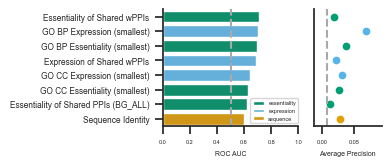

In [10]:
def plot_roc_pr(pred_df):
    sns.set_theme(style="ticks")

    f, ax = plt.subplots(ncols=2, nrows=1, figsize=(3.95, 1.7), sharey=True, gridspec_kw={'width_ratios': [2, 1]})
    
    colors = ["#009E73", "#56B4E9", '#E69F00']
    sns.set_palette(sns.color_palette(colors))

    sns.barplot(data=pred_df, x='mean_roc_auc', y='label', hue='category', palette=colors, saturation=0.8, dodge=False, ax=ax[0])
    ax[0].set_xlabel('ROC AUC', size=5) 
    ax[0].set_ylabel('')
    ax[0].set_xlim(0, 1)
    ax[0].tick_params('x', labelsize=4)
    ax[0].tick_params('y', labelsize=6)
    ax[0].axvline(x=0.5, linestyle='--', color='darkgrey')
    ax[0].legend(loc='lower right', fontsize=4, bbox_to_anchor=(1.02, 0))

    sns.pointplot(data=pred_df, x='avg_precision', y='label', hue='category', palette=colors,
                  dodge=False, markers='o', linestyles='none', errorbar=None, ax=ax[1])
    for line in plt.gca().lines:
        line.set_markersize(3.5)
    ax[1].set_xlabel('Average Precision', size=5) 
    ax[1].set_xlim(pred_df['avg_precision'].min()-0.025, pred_df['avg_precision'].max()+0.025)
    
    # Remove y-ticks for ax[1]
    ax[1].tick_params('y', left=False, labelleft=False)
    ax[1].tick_params('x', labelsize=4)
    ax[1].axvline(x=0.0087, linestyle='--', color='darkgrey')
    ax[1].legend().remove()

    # Remove top and right borders
    sns.despine(ax=ax[0], top=True, right=True)
    sns.despine(ax=ax[1], top=True, right=True)

    plt.tight_layout(pad=0.7)
    #plt.show()
    #plt.savefig(figure_path_b, bbox_inches="tight", dpi=300)

plot_roc_pr(pred_df)

### Box Plot

In [11]:
box_feature_ppi = ['ranked_BioGRID_ALL', 'ranked_Essentiality_weighted_PPI', 
                   'smallest_GO_ranked_ess', 'smallest_GO_CC_ranked_ess',
                   'smallest_gene_expression', 'smallest_GO_CC_expression',
                   'Expression_weighted_PPI', 'max_seq_id']
box_labels_ppi = ['Essentiality of Shared PPIs (BG_ALL)', 'Essentiality of Shared wPPIs', 
                  'GO BP Essentiality (smallest)', 'GO CC Essentiality (smallest)',
                  'GO BP Expression (smallest)', 'GO CC Expression (smallest)',
                  'Expression of Shared wPPIs',  'Sequence Identity']

display(dict(zip(box_feature_ppi, box_labels_ppi)))

{'ranked_BioGRID_ALL': 'Essentiality of Shared PPIs (BG_ALL)',
 'ranked_Essentiality_weighted_PPI': 'Essentiality of Shared wPPIs',
 'smallest_GO_ranked_ess': 'GO BP Essentiality (smallest)',
 'smallest_GO_CC_ranked_ess': 'GO CC Essentiality (smallest)',
 'smallest_gene_expression': 'GO BP Expression (smallest)',
 'smallest_GO_CC_expression': 'GO CC Expression (smallest)',
 'Expression_weighted_PPI': 'Expression of Shared wPPIs',
 'max_seq_id': 'Sequence Identity'}

In [12]:
def draw_signif_line(ax, x0, x1, y, pval, hd=20):
    """Draws a significance line between two box plots."""
    h = y / hd
    if pval < 0.0001: 
        text = '$p$=%.1e' % pval
    else: 
        text = '$p$=%.4f' % pval
    ax.plot([x0, x0, x1, x1], [y + h, y + 2 * h, y + 2 * h, y + h], lw=1, c='#666')
    ax.text((x0 + x1) * .5, y + 2.5 * h, text, ha='center', va='bottom', color='#666', fontsize=5)

In [13]:
def compute_upper_whisker(df, feature):
    """Computes the upper whisker of a box plot for a given feature."""
    Q1 = df[feature].quantile(q=0.25)
    Q3 = df[feature].quantile(q=0.75)
    IQR = Q3 - Q1
    return df[df[feature] <= (Q3 + 1.5 * IQR)][feature].max()

In [14]:
def draw_cont_graph(df, feature, target_column, ax, label=None, fliers=True, show_points=True, draw_signif=True, hd=20):
    # Define the color palette based on feature names
    color_mapping = {
        'ranked_BioGRID_ALL': '#009E73',
        'ranked_Essentiality_weighted_PPI': '#009E73',
        'smallest_GO_ranked_ess': '#009E73',
        'smallest_GO_CC_ranked_ess': '#009E73',
        'smallest_gene_expression': '#56B4E9',
        'smallest_GO_CC_expression': '#56B4E9',
        'Expression_weighted_PPI': '#56B4E9',
        'max_seq_id': '#E69F00'
    }

    # Set the colors for False and True based on the feature
    true_color = color_mapping.get(feature, '#8491B4FF')  # default to original color if feature not in mapping
    my_pal = {False: "white", True: true_color}

    # Calculate the counts of SL and not_SL
    count_SL = (df[target_column] == True).sum()
    count_not_SL = (df[target_column] == False).sum()
    
    sns.despine(top=True, right=True, left=False, bottom=False)
    sns.boxplot(y=feature, x=target_column, hue=target_column, data=df, ax=ax, linewidth=0.8, saturation=0.8, 
                showfliers=False, showmeans=False, palette=my_pal, order=[False, True], 
                boxprops={'edgecolor':'black', 'alpha':0.85}, medianprops={'color':'black', 'linewidth':0.8})
    
    ax.set_ylabel(label if label else feature, fontsize=5.75)
    ax.set_xlabel('')
    ax.set_xticks([0, 1])
    ax.set_xticklabels([f'not_SL \n(n={count_not_SL})', f'SL \n(n={count_SL})'], fontsize=6)
    ax.tick_params(axis='y', rotation=0, labelsize=4)
    ax.legend().remove()

    #if show_points:
    #    sns.stripplot(y=feature, x=target_column, data=df, color='silver', ax=ax, alpha=0.7, size=2, zorder=0)
    #    ax.set_xlabel('')
    #    ax.legend().remove()

    if draw_signif:
        pval = stats.mannwhitneyu(df.loc[df[target_column] == True, feature], df.loc[df[target_column] == False, feature], alternative="two-sided")[1]
        upper_whisker = max(compute_upper_whisker(df.loc[df[target_column] == True], feature), compute_upper_whisker(df.loc[df[target_column] == False], feature))
        draw_signif_line(ax, 0, 1, upper_whisker + 0.05, pval, hd)


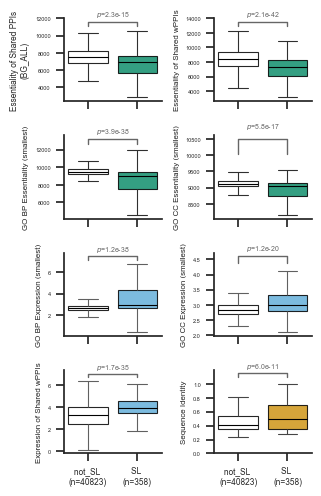

In [15]:
f, ax = plt.subplots(4, 2, figsize=(3.25, 5), sharex=True)  
ax = ax.flatten()
for i in range(len(box_feature_ppi)):
    draw_cont_graph(df_clean, box_feature_ppi[i], target_column, ax[i], label=box_labels_ppi[i])

ax[0].set_ylabel('Essentiality of Shared PPIs \n(BG_ALL)', fontsize=6)
ax[7].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.tight_layout(pad=0.7)
#f.savefig(figure_path_a, bbox_inches="tight", dpi=300)
#plt.show()  